# Efficiently run SetFit Models with Optimum

[SetFit](https://github.com/huggingface/setfit) is a technique for few-shot text classification that uses contrastive learning to fine-tune Sentence Transformers in domains where little to no labeled data is available. It achieves comparable performance to existing state-of-the-art methods based on large language models, yet requires no prompts and is efficient to train (typically a few seconds on a GPU to minutes on a CPU).

In this notebook you'll learn how to further compress SetFit models for faster inference & deployment on GPU using Optimum Onnx.

## 1. Setup development environment

Our first step is to install SetFit. Running the following cell will install all the required packages for us.

In [156]:
!pip install setfit accelerate -qqq

## 2. Create a performance benchmark

Before we train and optimize any models, let's define a performance benchmark that we can use to compare our models. In general, deploying ML models in production environments involves a tradeoff among several constraints:

* Model performance: how well does the model perform on a well crafted test set?
* Latency: how fast can our model deliver predictions?
* Memory: on what cloud instance or device can we store and load our model?

The class below defines a simple benchmark that measure each quantity for a given SetFit model and test dataset:

In [157]:
from pathlib import Path
from time import perf_counter

import evaluate
import numpy as np
import torch
from tqdm.auto import tqdm

metric = evaluate.load("accuracy")


class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_model(self, query="that loves its characters and communicates something rather beautiful about human nature"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.model([query])
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(rf"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.time_model())
        return metrics

Beyond that, we'll create a simple function to plot the performances reported by this benchmark.

In [194]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        plt.errorbar(
            df_opt["time_avg_ms"],
            df_opt["accuracy"] * 100,
            xerr=df_opt["time_std_ms"],
            fmt="o",
            alpha=0.5,
            ms=df_opt["size_mb"] / 15,
            label=idx,
            capsize=5,
            capthick=1,
        )

    legend = plt.legend(loc="lower right")

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = max([metrics["time_avg_ms"] for metrics in perf_metrics.values()]) * 1.2
    plt.xlim(0, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency with batch_size=1 (ms)")
    plt.show()


## 3. Train/evaluate bge-small SetFit models

Before we optimize any models, let's train a few baselines as a point of reference. We'll use the [sst-2](https://huggingface.co/datasets/SetFit/sst2) dataset, which is a collection of sentiment text catagorized into 2 classes: positive, negative

Let's start by loading the dataset from the Hub:

In [159]:
from datasets import load_dataset

dataset = load_dataset("SetFit/sst2")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1821
    })
})

We train a SetFit model with the full dataset. Recall that SetFit excels with few-shot scenario, but this time we are interested to achieve maximum accuracy.

In [160]:
train_dataset = dataset["train"]
test_dataset = dataset["validation"]

Use the following line code to download the [already finetuned model](https://huggingface.co/moshew/bge-small-en-v1.5_setfit-sst2-english) and evaluate. Alternatively, uncomment the code below it to fine-tune the base model from scratch.

Note that we perform the evaluations on Google Colab using the free T4 GPU.

In [197]:
# Evaluate the uploaded model!
from setfit import SetFitModel

small_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
pb = PerformanceBenchmark(model=small_model, dataset=test_dataset, optim_type="bge-small (PyTorch)")
perf_metrics = pb.run_benchmark()

Model size (MB) - 127.33
Accuracy on test set - 0.906
Average latency (ms) - 13.43 +\- 1.62


In [162]:
# # Fine-tune the base model and Evaluate!
# from setfit import SetFitModel, Trainer, TrainingArguments

# # Load pretrained model from the Hub
# small_model = SetFitModel.from_pretrained(
#    "BAAI/bge-small-en-v1.5"
# )
# args = TrainingArguments(num_iterations=20)

# # Create trainer
# small_trainer = Trainer(
#    model=small_model, args=args, train_dataset=train_dataset
# )
# # Train!
# small_trainer.train()

# # Evaluate!
# pb = PerformanceBenchmark(
#    model=small_trainer.model, dataset=test_dataset, optim_type="bge-small (base)"
# )
# perf_metrics = pb.run_benchmark()

Let's plot the results to visualise the performance:

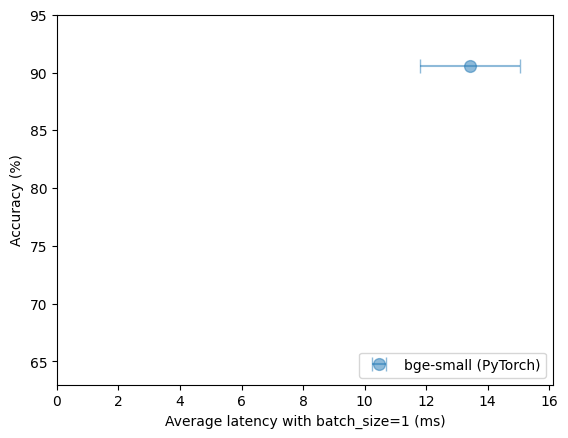

In [198]:
plot_metrics(perf_metrics)

## 4. Compressing with Optimum ONNX and CUDAExecutionProvider

We'll be using Optimum's ONNX Runtime support with `CUDAExecutionProvider` [because it's fast while also supporting dynamic shapes](https://github.com/huggingface/optimum-benchmark/tree/main/examples/fast-mteb#notes).

In [164]:
!pip install optimum[onnxruntime-gpu] -qqq

[`optimum-cli`](https://huggingface.co/docs/optimum/onnxruntime/usage_guides/optimization#optimizing-a-model-during-the-onnx-export) makes it extremely easy to export a model to ONNX and apply SOTA graph optimizations / kernel fusions.

In [165]:
!optimum-cli export onnx \
  --model moshew/bge-small-en-v1.5_setfit-sst2-english \
  --task feature-extraction \
  --optimize O4 \
  --device cuda \
  bge_auto_opt_O4

2023-11-27 12:23:25.781950: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 12:23:25.782000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 12:23:25.782035: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 12:23:26.931536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.
Using framework PyTorch: 2.1.0+cu118
Overriding 1 configuration item(s)
	- use_cache -

We may see some warnings, but these are not ones to be concerned about. We'll see later that it does not affect the model performance.

First of all, we'll create a subclass of our performance benchmark to also allow benchmarking ONNX models.

In [166]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

Then, we can load the converted SentenceTransformer model with the `"CUDAExecutionProvider"` provider. Feel free to also experiment with other providers, such as `"TensorrtExecutionProvider"` and `"CPUExecutionProvider"`. The former may be even faster than `"CUDAExecutionProvider"`, but requires more installation.

In [169]:
import torch
from transformers import AutoTokenizer
from optimum.onnxruntime import ORTModelForFeatureExtraction

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('bge_auto_opt_O4', model_max_length=512)
ort_model = ORTModelForFeatureExtraction.from_pretrained('bge_auto_opt_O4', provider="CUDAExecutionProvider")

And let's make a class that uses the tokenizer, ONNX Runtime (ORT) model and a model head.

In [170]:
from setfit.exporters.utils import mean_pooling


class OnnxSetFitModel:
    def __init__(self, ort_model, tokenizer, model_head):
        self.ort_model = ort_model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        ).to(self.ort_model.device)

        outputs = self.ort_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings.cpu())

    def __call__(self, inputs):
        return self.predict(inputs)

We can initialize this model like so:

In [171]:
model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
onnx_setfit_model = OnnxSetFitModel(ort_model, tokenizer, model.model_head)

# Perform inference
onnx_setfit_model(test_dataset["text"][:2])

array([0, 0])

Time to benchmark this ONNX model.

In [201]:
pb = OnnxPerformanceBenchmark(
    onnx_setfit_model,
    test_dataset,
    "bge-small (optimum ONNX)",
    model_path="bge_auto_opt_O4/model.onnx",
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 63.39
Accuracy on test set - 0.906
Average latency (ms) - 2.19 +\- 0.50


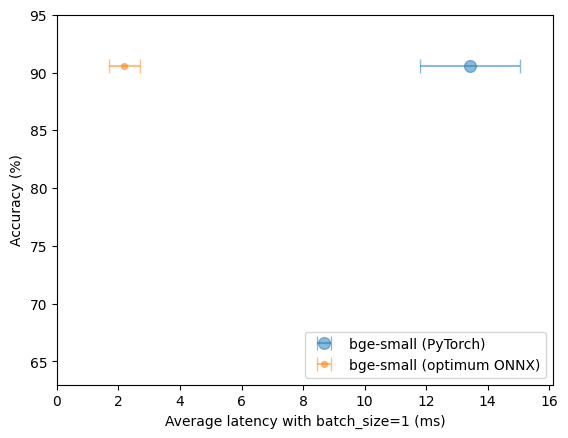

In [202]:
plot_metrics(perf_metrics)

By applying ONNX, we were able to improve the latency from 13.43ms per sample to 2.19ms per sample, for a speedup of 6.13x!

For further improvements, we recommend increasing the inference batch size, as this may also heavily improve the throughput. For example, setting the batch size to 128 reduces the latency further down to 0.3ms, and down to 0.2ms at a batch size of 2048.